# German License Plate Recognition

Training of a model for the recognition of German license plates in pictures taken by a smartphone camara.

### Importing Packages

In [1]:
import cv2
import os
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
from scipy import misc
from skimage import data
import glob
import shutil

print ("TensorFlow Version: {}".format(tf.__version__))

device_name = tf.test.gpu_device_name()

if device_name != "/device:GPU:0":
    raise SystemError("GPU device not found")

print(f"GPU device: {device_name}")

TensorFlow Version: 2.1.0-rc2
GPU device: /device:GPU:0


### Training Parameter

In [2]:
from config import config

# datasets
GLP_HDF5 = config.GLP_HDF5
BACKGRND_HDF5 = config.BACKGRND_HDF5

# image size <=> network input size
IMAGE_WIDTH = config.IMAGE_WIDTH
IMAGE_HEIGHT = config.IMAGE_HEIGHT

# training parameter
DOWNSAMPLE_FACTOR = config.DOWNSAMPLE_FACTOR
MAX_TEXT_LEN = config.MAX_TEXT_LEN

BATCH_SIZE = config.BATCH_SIZE
NUM_EPOCHS = config.NUM_EPOCHS

# supported optimizer methods: sdg, rmsprop, adam, adagrad, adadelta
OPTIMIZER = config.OPTIMIZER

OUTPUT_PATH = config.OUTPUT_PATH
DOCUMENTATION_PATH = config.DOCUMENTATION_PATH
MODEL_NAME = config.MODEL_NAME

MODEL_WEIGHTS_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + '-weights.h5'
MODEL_PATH = os.path.join(OUTPUT_PATH, OPTIMIZER, MODEL_NAME) + ".h5"
TEST_IMAGES = config.TEST_IMAGES

# create model output directory
os.makedirs(os.path.join(config.OUTPUT_PATH, OPTIMIZER), exist_ok=True)

print("GLP Dataset:        {}".format(GLP_HDF5))
print("Background Dataset: {}".format(BACKGRND_HDF5))
print("Batch Size:         {}".format(BATCH_SIZE))
print("Epochs (max):       {}".format(NUM_EPOCHS))
print("Image Size:         ({}, {})".format(IMAGE_WIDTH, IMAGE_HEIGHT))
print("Optimizer:          {}".format(OPTIMIZER))
print("Model Name:         {}".format(MODEL_NAME))
print("Output Path:        {}".format(OUTPUT_PATH))
print("Model Weights Path: {}".format(MODEL_WEIGHTS_PATH))
print("Model Path:         {}".format(MODEL_PATH))
print("Documentation Path: {}".format(DOCUMENTATION_PATH))

GLP Dataset:        D:\development\tensorflow\ANPR\..\datasets\german_license_plates\glp.h5
Background Dataset: D:\development\tensorflow\ANPR\..\datasets\german_license_plates\background.h5
Batch Size:         64
Epochs (max):       1000
Image Size:         (128, 64)
Optimizer:          adagrad
Model Name:         glpr-model
Output Path:        output
Model Weights Path: output\adagrad\glpr-model-weights.h5
Model Path:         output\adagrad\glpr-model.h5
Documentation Path: documentation


### Data Loading

In [3]:
from pyimagesearch.io import Hdf5DatasetLoader
from sklearn.model_selection import train_test_split

loader = Hdf5DatasetLoader()
images, labels = loader.load(GLP_HDF5, shuffle=True)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2)

print("Train dataset size:      {}".format(X_train.shape[0]))
print("Validation dataset size: {}".format(X_val.shape[0]))
print("Test dataset size:       {}".format(X_test.shape[0]))


Train dataset size:      91561
Validation dataset size: 22891
Test dataset size:       28614


C:\Users\Andreas\Anaconda3\envs\dl4cv\lib\site-packages\matplotlib\text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


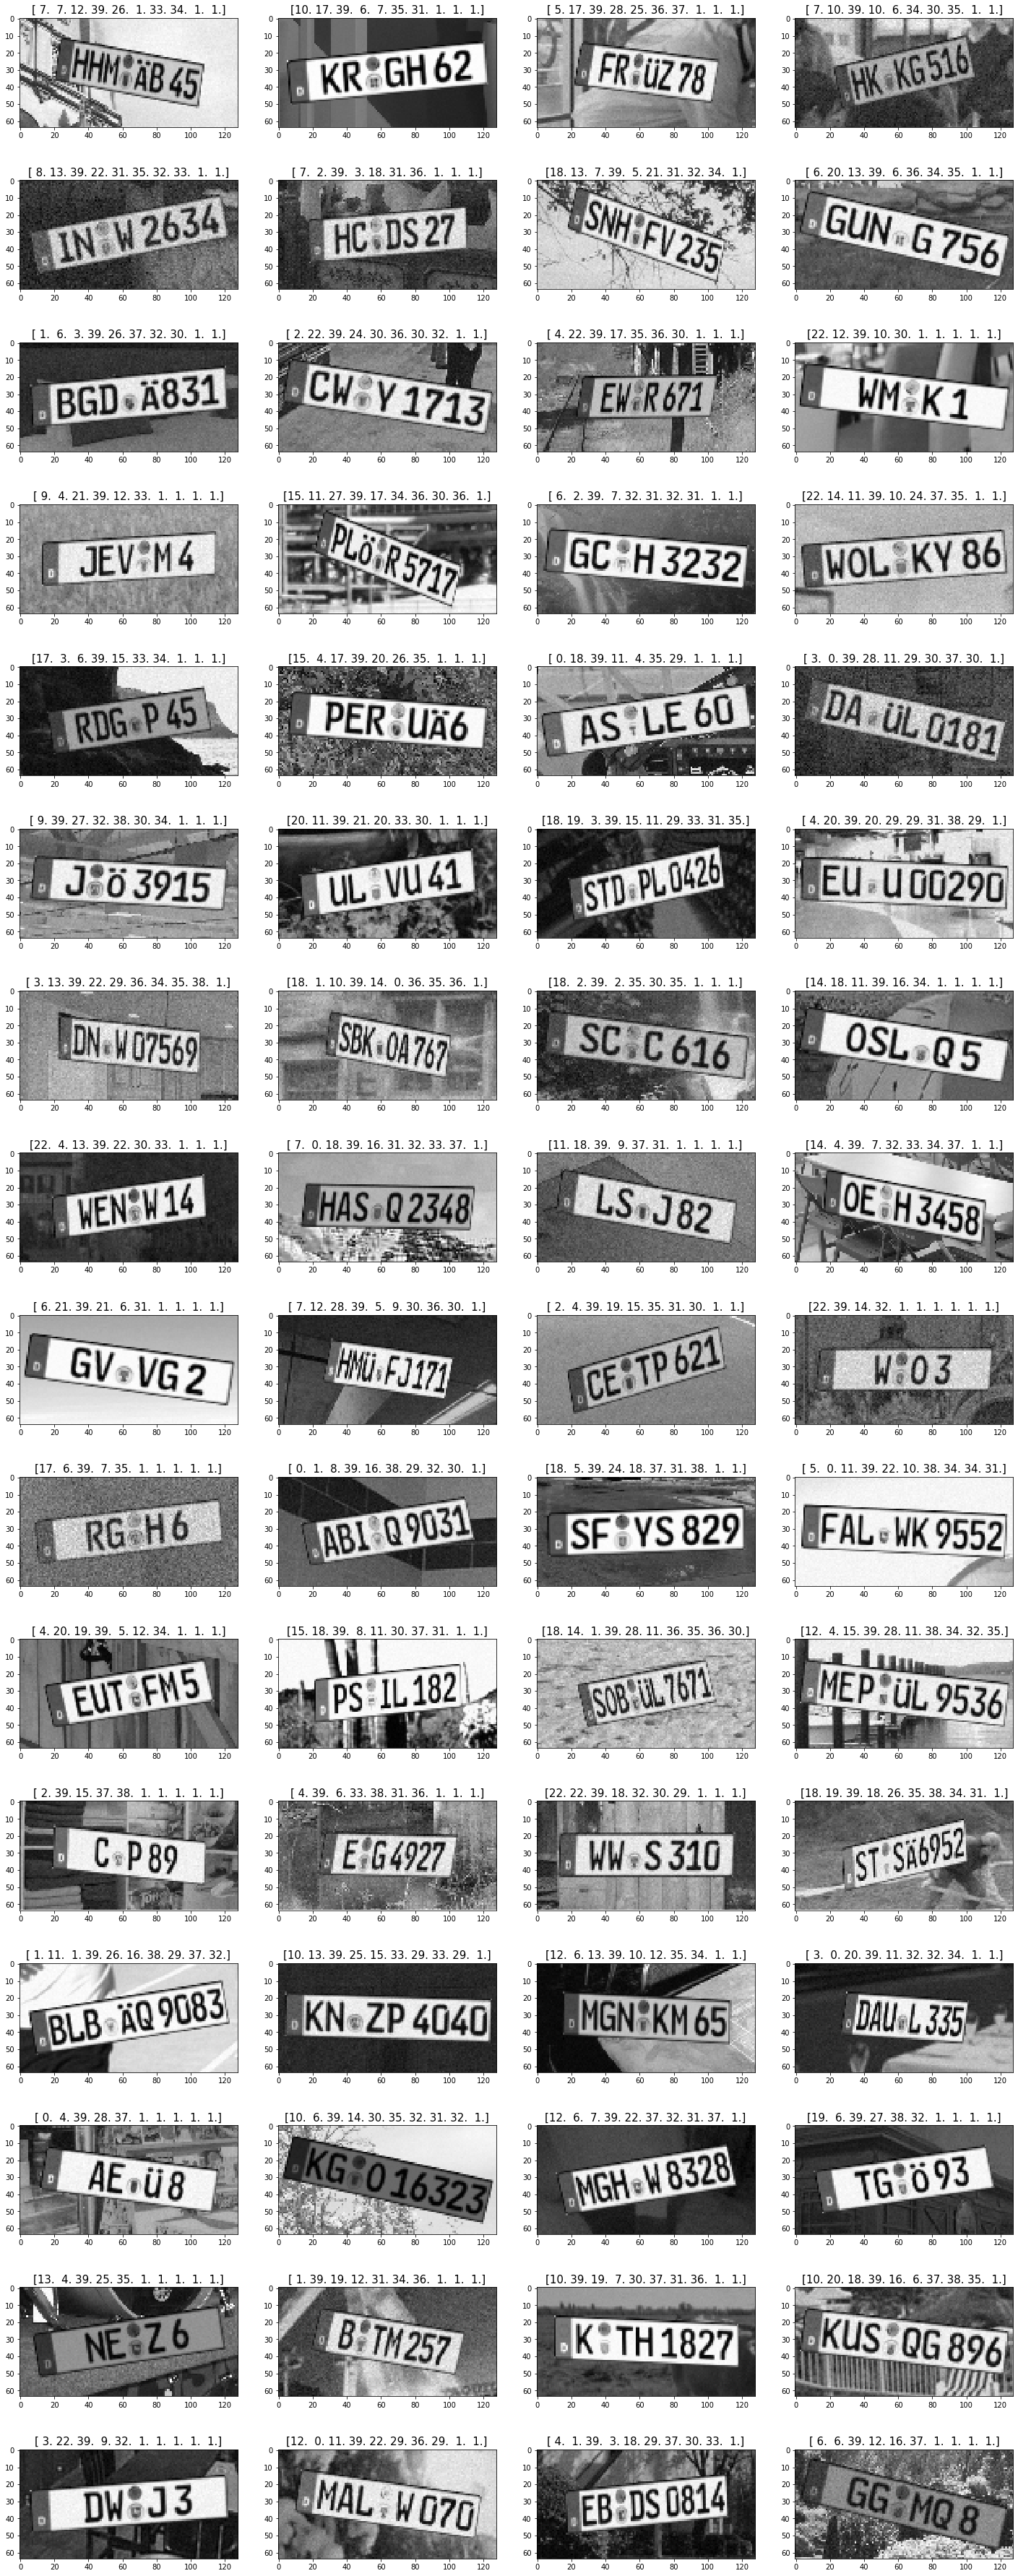

In [4]:
from pyimagesearch.io import Hdf5DatasetLoader
from license_plate_image_augmentator import LicensePlateImageAugmentator
from licence_plate_dataset_generator import LicensePlateDatasetGenerator
from label_codec import LabelCodec
import skimage

background_images = loader.load(BACKGRND_HDF5, shuffle=True, max_items=10000)

augmentator = LicensePlateImageAugmentator(IMAGE_WIDTH, IMAGE_HEIGHT, background_images)

train_generator = LicensePlateDatasetGenerator(X_train, y_train, IMAGE_WIDTH, IMAGE_HEIGHT,
                                               DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                               augmentator)

val_generator = LicensePlateDatasetGenerator(X_val, y_val, IMAGE_WIDTH, IMAGE_HEIGHT,
                                             DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                             augmentator)

test_generator = LicensePlateDatasetGenerator(X_test, y_test, IMAGE_WIDTH, IMAGE_HEIGHT,
                                              DOWNSAMPLE_FACTOR, MAX_TEXT_LEN, BATCH_SIZE,
                                              augmentator)

inputs = next(train_generator.generator())

def plotImages(images_arr, labels, rows, columns):
    fig, axes = plt.subplots(rows, columns, figsize=(20,50))
    axes = axes.flatten()
    for img, label, ax in zip(images_arr, labels, axes):
        img = img.T.reshape(IMAGE_HEIGHT, IMAGE_WIDTH)
        ax.title.set_size(15)
        ax.title.set_text(label)
        ax.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.show()
        
plotImages(inputs["input"], inputs["labels"], int(BATCH_SIZE / 4), 4)

### Create and train the CRNN

In [5]:
from tensorflow.keras.optimizers import SGD, Adam, Adagrad, Adadelta, RMSprop
from tensorflow.python.keras import Input
from tensorflow.python.keras.models import Model
from pyimagesearch.nn.conv import OCR
from label_codec import LabelCodec
from train_helper import TrainHelper
    
class CTCLoss(tf.keras.losses.Loss):

    def __init__(self, input_length, label_length, name='CTCLoss'):
        super().__init__(name=name)
        self.input_length = input_length
        self.label_length = label_length

    def call(self, labels, predictions):
        return tf.keras.backend.ctc_batch_cost(labels, predictions, self.input_length, self.label_length)

tf.compat.v1.disable_eager_execution()

labels = Input(name='labels', shape=(MAX_TEXT_LEN,), dtype='float32')
input_length = Input(name='input_length', shape=(1,), dtype='int64')
label_length = Input(name='label_length', shape=(1,), dtype='int64')

inputs, outputs = OCR.conv_bgru((IMAGE_WIDTH, IMAGE_HEIGHT, 1), len(LabelCodec.ALPHABET) + 1)

train_model = Model(inputs=[inputs, labels, input_length, label_length], outputs=outputs)
train_model.add_loss(CTCLoss(input_length, label_length)(labels, outputs))
train_model.compile(loss=None, optimizer=TrainHelper.get_optimizer(OPTIMIZER))

predict_model = Model(inputs=inputs, outputs=outputs)
predict_model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 128, 64, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 128, 64, 16)       160       
_________________________________________________________________
batch_normalization (BatchNo (None, 128, 64, 16)       64        
_________________________________________________________________
activation (Activation)      (None, 128, 64, 16)       0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 32, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 64, 32, 16)        2320      
____________________________________________

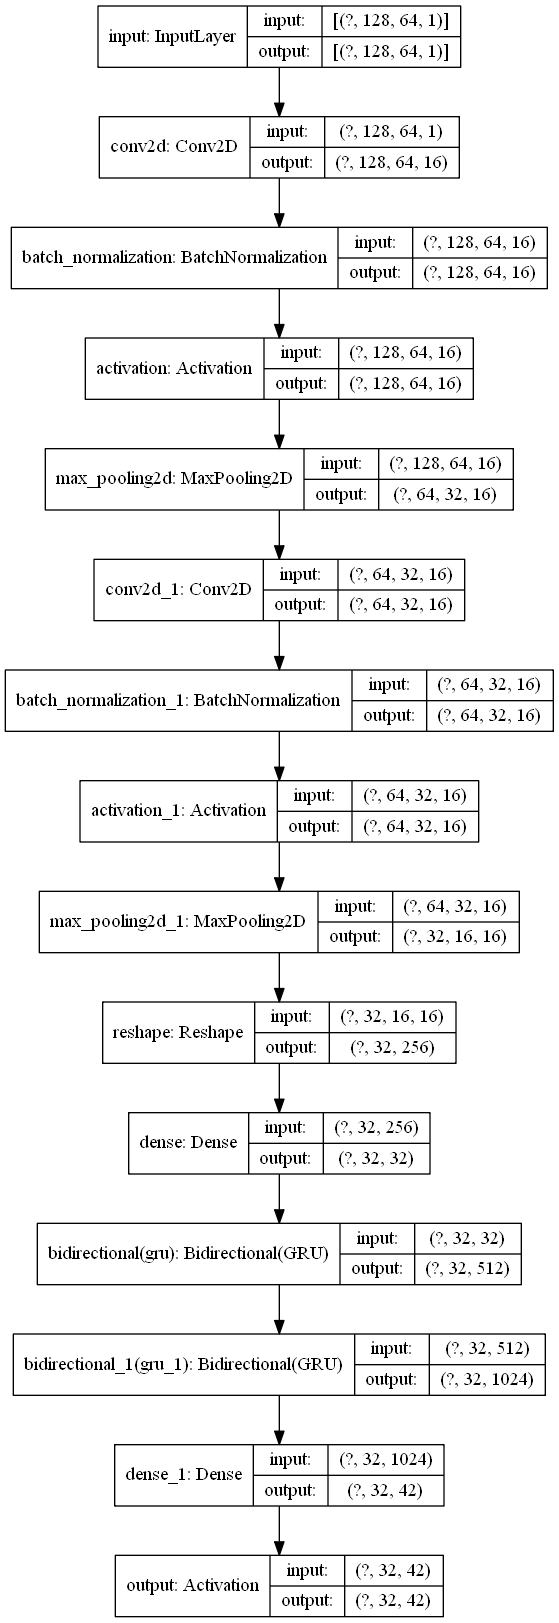

In [6]:
from tensorflow.keras.utils import plot_model
from IPython.display import Image

model_architecture_file = os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + '.png'
plot_model(predict_model, to_file=model_architecture_file, show_shapes=True)
Image(filename=model_architecture_file, width=400)

#### Train the network

In [7]:
history = train_model.fit(
    train_generator.generator(),
    steps_per_epoch=train_generator.numImages // BATCH_SIZE,
    validation_data=val_generator.generator(),
    validation_steps=val_generator.numImages // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=TrainHelper.get_callbacks(OPTIMIZER, MODEL_WEIGHTS_PATH), verbose=1)

Epoch 1/1000
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
 357/1430 [======>.......................] - ETA: 5:19 - loss: 19.5478
Epoch 00001: val_loss improved from inf to 19.54780, saving model to output\adagrad\glpr-model-weights.h5
1430/1430 [==============================] - 617s 431ms/step - loss: 21.8746 - val_loss: 19.5478
Epoch 2/1000
 357/1430 [======>.......................] - ETA: 5:11 - loss: 6.3617
Epoch 00002: val_loss improved from 19.54780 to 6.36166, saving model to output\adagrad\glpr-model-weights.h5
1430/1430 [==============================] - 614s 429ms/step - loss: 12.0950 - val_loss: 6.3617
Epoch 3/1000
 357/1430 [======>.......................] - ETA: 5:18 - loss: 2.3526
Epoch 00003: val_loss improved from 6.36166 to 2.35261, saving model to output\adagrad\glpr-model-weights.h5
1430/1430 [==============================] - 615s 430ms/step - loss: 3.9983 - val_loss: 2.3526
Epoch 4/1000
 357/1

 357/1430 [======>.......................] - ETA: 5:10 - loss: 0.1573
Epoch 00022: val_loss improved from 0.15922 to 0.15734, saving model to output\adagrad\glpr-model-weights.h5
1430/1430 [==============================] - 603s 422ms/step - loss: 0.1620 - val_loss: 0.1573
Epoch 23/1000
 357/1430 [======>.......................] - ETA: 5:08 - loss: 0.1501
Epoch 00023: val_loss improved from 0.15734 to 0.15006, saving model to output\adagrad\glpr-model-weights.h5
1430/1430 [==============================] - 604s 422ms/step - loss: 0.1562 - val_loss: 0.1501
Epoch 24/1000
 357/1430 [======>.......................] - ETA: 5:09 - loss: 0.1592
Epoch 00024: val_loss did not improve from 0.15006
1430/1430 [==============================] - 603s 421ms/step - loss: 0.1567 - val_loss: 0.1592
Epoch 25/1000
 357/1430 [======>.......................] - ETA: 5:08 - loss: 0.1366
Epoch 00025: val_loss improved from 0.15006 to 0.13658, saving model to output\adagrad\glpr-model-weights.h5
1430/1430 [====

#### Create and save prediction model

In [8]:
from tensorflow.keras.models import save_model

predict_model.load_weights(MODEL_WEIGHTS_PATH)
save_model(predict_model, filepath=MODEL_PATH, save_format="h5")

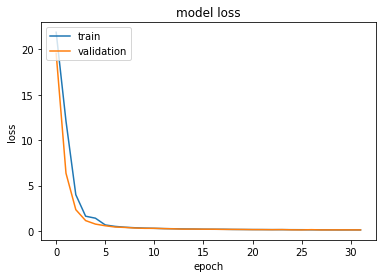

In [9]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.savefig(os.path.join(DOCUMENTATION_PATH, MODEL_NAME) + "-train-history-" + OPTIMIZER + ".png")
plt.show()

In [10]:
inputs = next(test_generator.generator())
score = train_model.evaluate(inputs, verbose=0)
print('Test loss: {0:.4f}'.format(score))

Test loss: 0.2228


In [11]:
predict_model.save(os.path.join(OUTPUT_PATH, OPTIMIZER, "out-tf"), save_format='tf')

INFO:tensorflow:Assets written to: output\adagrad\out-tf\assets


In [12]:
tf.saved_model.save(predict_model, os.path.join(OUTPUT_PATH, OPTIMIZER, "saved_model"))

INFO:tensorflow:Assets written to: output\adagrad\saved_model\assets
